## Generate datasets

In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data as data
from torch.utils.data import DataLoader, TensorDataset, Dataset

from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm

from typing import Dict, List, Optional, Tuple

In [ ]:
dataset1 = np.zeros((100, 2)) + 5
dataset1[:, 0] = np.random.randn(100)

dataset2 = np.zeros((100, 2))
dataset2[:, 1] = np.random.randn(100)

## Autoencoder

In [ ]:
INPUT_DIM = 2
HIDDEN_DIM = 16
NUM_EPOCHS = 20
BATCH_SIZE = 32

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            # nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cpu


In [ ]:
def extract_singular_values_from_layer(weight_tensor):
    if len(weight_tensor.shape) == 4:
        out_channels, in_channels, kernel_height, kernel_width = weight_tensor.shape
    else:
        out_channels, in_channels = weight_tensor.shape
    weight_matrix = weight_tensor.reshape(out_channels, -1)

    U, S, Vt = np.linalg.svd(weight_matrix)
    return S

def extract_singular_values_from_encoder(weights):
    singular_values_list = []
    for layer_weights in weights:
        singular_values = extract_singular_values_from_layer(layer_weights)
        singular_values_list.append(singular_values)
    return singular_values_list

def get_vector(model):
    weights = []
    for layer in model.encoder:  # [model.encoder]
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            weights.append(layer.weight.data.cpu().numpy())
    for layer in model.decoder:  # [model.decoder]
        if isinstance(layer, nn.ConvTranspose2d) or isinstance(layer, nn.Linear):
            weights.append(layer.weight.data.cpu().numpy())
    singular_values_list = extract_singular_values_from_encoder(weights)
    return np.concatenate(singular_values_list)

In [ ]:
def train_model(model: Autoencoder, train_loader: DataLoader, num_epochs: int) -> Autoencoder:
    """
    Обучение автоэнкодера

    Args:
        model: модель автоэнкодера
        train_loader: загрузчик данных для обучения
        num_epochs: количество эпох обучения

    Returns:
        Обученная модель
    """
    model.to(DEVICE)
    model.train()
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        for inputs_list in train_loader:
            inputs = inputs_list[0]  # Особенность TensorDataset в DataLoader

            # ============ Forward ============
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            # ============ Backward ============
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return model

def train_models(
    num_models: int,
    mean: np.array,
    std: np.array,
) -> List[np.array]:
    """
    Обучение нескольких автоэнкодеров в цикле с сохранением весов и векторов

    Args:
        num_models: количество обучаемых автоэнкодеров

    Returns:
        vectors: список векторов закодированных автоэнкодеров
    """
    vectors = []
    for i in tqdm(range(num_models)):
        train_data_np = np.random.normal(loc=mean, scale=std, size=(500, mean.shape[0]))
        train_data_tensor = torch.tensor(train_data_np).float().to(DEVICE)
        train_dataset_tensor = TensorDataset(train_data_tensor)
        train_loader = DataLoader(train_dataset_tensor, batch_size=BATCH_SIZE, shuffle=True)

        model = Autoencoder(INPUT_DIM, HIDDEN_DIM)
        trained_model = train_model(model, train_loader, NUM_EPOCHS)
        vector = get_vector(trained_model)
        vectors.append(vector)

        # trained_model.eval()
        # with torch.no_grad():
        #     outputs = trained_model(train_data_tensor.detach())
        #     plt.scatter(outputs[:, 0], outputs[:, 1])
        #     plt.show()
    return vectors

In [ ]:
# mean_1, std_1 = np.array([20, 50]*100), np.array([10, 7]*100)
# mean_2, std_2 = np.array([0, 10]*100), np.array([1, 2]*100)

mean_1, std_1 = np.array([20, 50]), np.array([1, 2])
mean_2, std_2 = np.array([0, 10]), np.array([1, 2])

num_models_train = 100
num_models_test = 100

vectors_1 = train_models(num_models_train, mean_1, std_1)
vectors_2 = train_models(num_models_train, mean_2, std_2)

vectors_1_test = train_models(num_models_test, mean_1, std_1)
vectors_2_test = train_models(num_models_test, mean_2, std_2)

100%|██████████| 100/100 [01:02<00:00,  1.59it/s]


In [ ]:
def train_eval_logreg(
    vectors_1: np.array,
    vectors_2: np.array,
    vectors_1_test: np.array,
    vectors_2_test: np.array,
    use_scaler: bool = False,
) -> Tuple[float, float, float]:
    train_size = len(vectors_1)
    test_size = len(vectors_1_test)

    X = np.vstack((vectors_1, vectors_2))
    y = np.array([0] * train_size + [1] * train_size)

    X_shuffled, y_shuffled = shuffle(X, y, random_state=42)

    if use_scaler:
      scaler_lr = StandardScaler()  # Опционально, с ним качество похуже (?)
      X_shuffled = scaler_lr.fit_transform(X_shuffled)

    logreg = LogisticRegression()
    logreg.fit(X_shuffled, y_shuffled)

    X_test = np.vstack((vectors_1_test, vectors_2_test))

    if use_scaler:
        X_test = scaler_lr.transform(X_test)
    y_test = np.array([0] * test_size + [1] * test_size)

    ap = average_precision_score(y_test, logreg.predict_proba(X_test)[:, 1])
    roc_auc = roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1])
    accuracy = accuracy_score(y_test, logreg.predict(X_test))

    return ap, roc_auc, accuracy

train_eval_logreg(
    vectors_1, vectors_2, vectors_1_test, vectors_2_test, use_scaler=True
)

(np.float64(0.6714751743480907), np.float64(0.6520000000000001), 0.62)

In [ ]:
train_size = len(vectors_1)
test_size = len(vectors_1_test)

X = np.vstack((vectors_1, vectors_2))
y = np.array([0] * train_size + [1] * train_size)

X_shuffled, y_shuffled = shuffle(X, y, random_state=42)

scaler_lr = StandardScaler()
X_shuffled = scaler_lr.fit_transform(X_shuffled)

logreg = LogisticRegression()
logreg.fit(X_shuffled, y_shuffled)

X_test = np.vstack((vectors_1_test, vectors_2_test))

X_test = scaler_lr.transform(X_test)
y_test = np.array([0] * test_size + [1] * test_size)

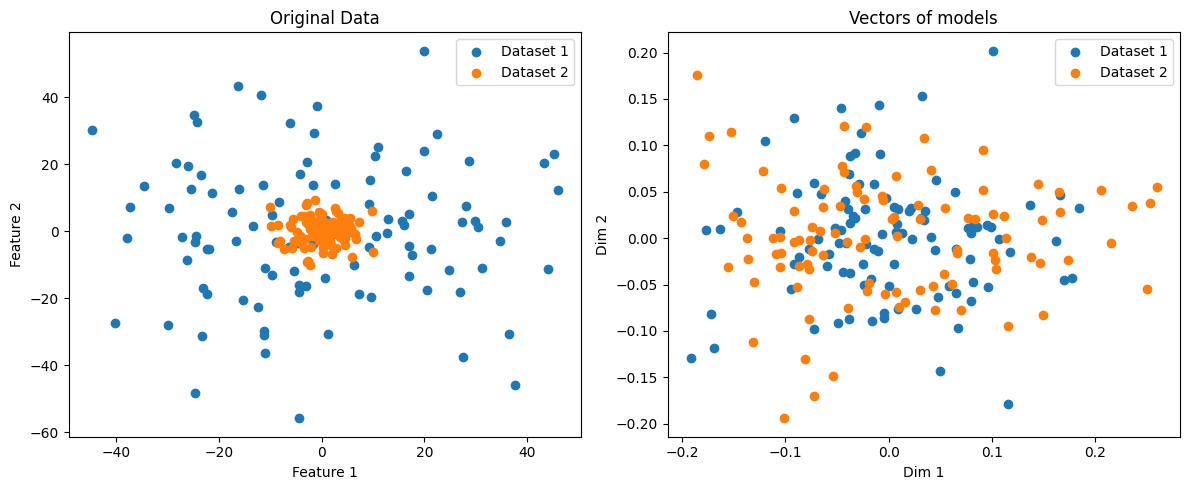

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

transformed_data1 = PCA(n_components=2).fit_transform(np.array(vectors_1))
transformed_data2 = PCA(n_components=2).fit_transform(np.array(vectors_2))

dataset1 = np.random.normal(loc=mean_1, scale=std_1, size=(100, mean_1.shape[0]))
dataset2 = np.random.normal(loc=mean_2, scale=std_2, size=(100, mean_2.shape[0]))

transformed_dataset1 = PCA(n_components=2).fit_transform(dataset1)
transformed_dataset2 = PCA(n_components=2).fit_transform(dataset2)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(transformed_dataset1[:, 0], transformed_dataset1[:, 1], label='Dataset 1')
plt.scatter(transformed_dataset2[:, 0], transformed_dataset2[:, 1], label='Dataset 2')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Original Data')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(transformed_data1[:, 0], transformed_data1[:, 1], label='Dataset 1')
plt.scatter(transformed_data2[:, 0], transformed_data2[:, 1], label='Dataset 2')
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.title('Vectors of models')
plt.legend()

plt.tight_layout()
plt.show()

## Apply pca

In [ ]:
from sklearn.decomposition import PCA

transformed_data1 = PCA(n_components=1).fit_transform(dataset1)
transformed_data2 = PCA(n_components=1).fit_transform(dataset2)

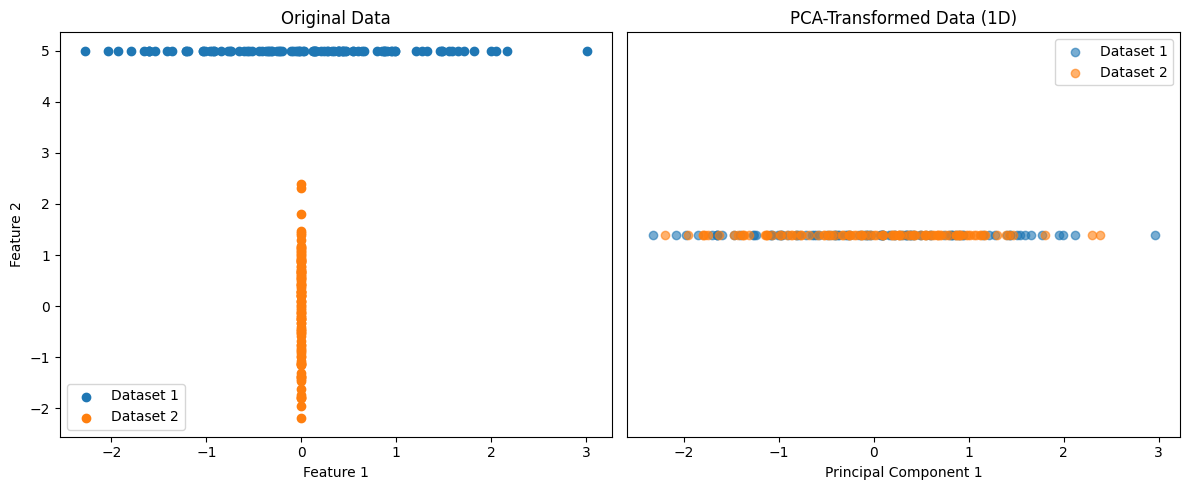

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(dataset1[:, 0], dataset1[:, 1], label='Dataset 1')
plt.scatter(dataset2[:, 0], dataset2[:, 1], label='Dataset 2')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Original Data')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(transformed_data1, np.zeros_like(transformed_data1), alpha=0.6, label='Dataset 1')
plt.scatter(transformed_data2, np.zeros_like(transformed_data2), alpha=0.6, label='Dataset 2')
plt.xlabel('Principal Component 1')
plt.title('PCA-Transformed Data (1D)')
plt.yticks([])
plt.legend()

plt.tight_layout()
plt.show()